## Imports:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Dataset Loading:

In [2]:
# Paths
train_dir = '../dataset/plant_dataset/train'
valid_dir = '../dataset/plant_dataset/valid'

# Image Data Generator with real-time augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_gen = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Class Weight Computation

In [3]:
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = dict(enumerate(class_weights))

## Visualize the data:

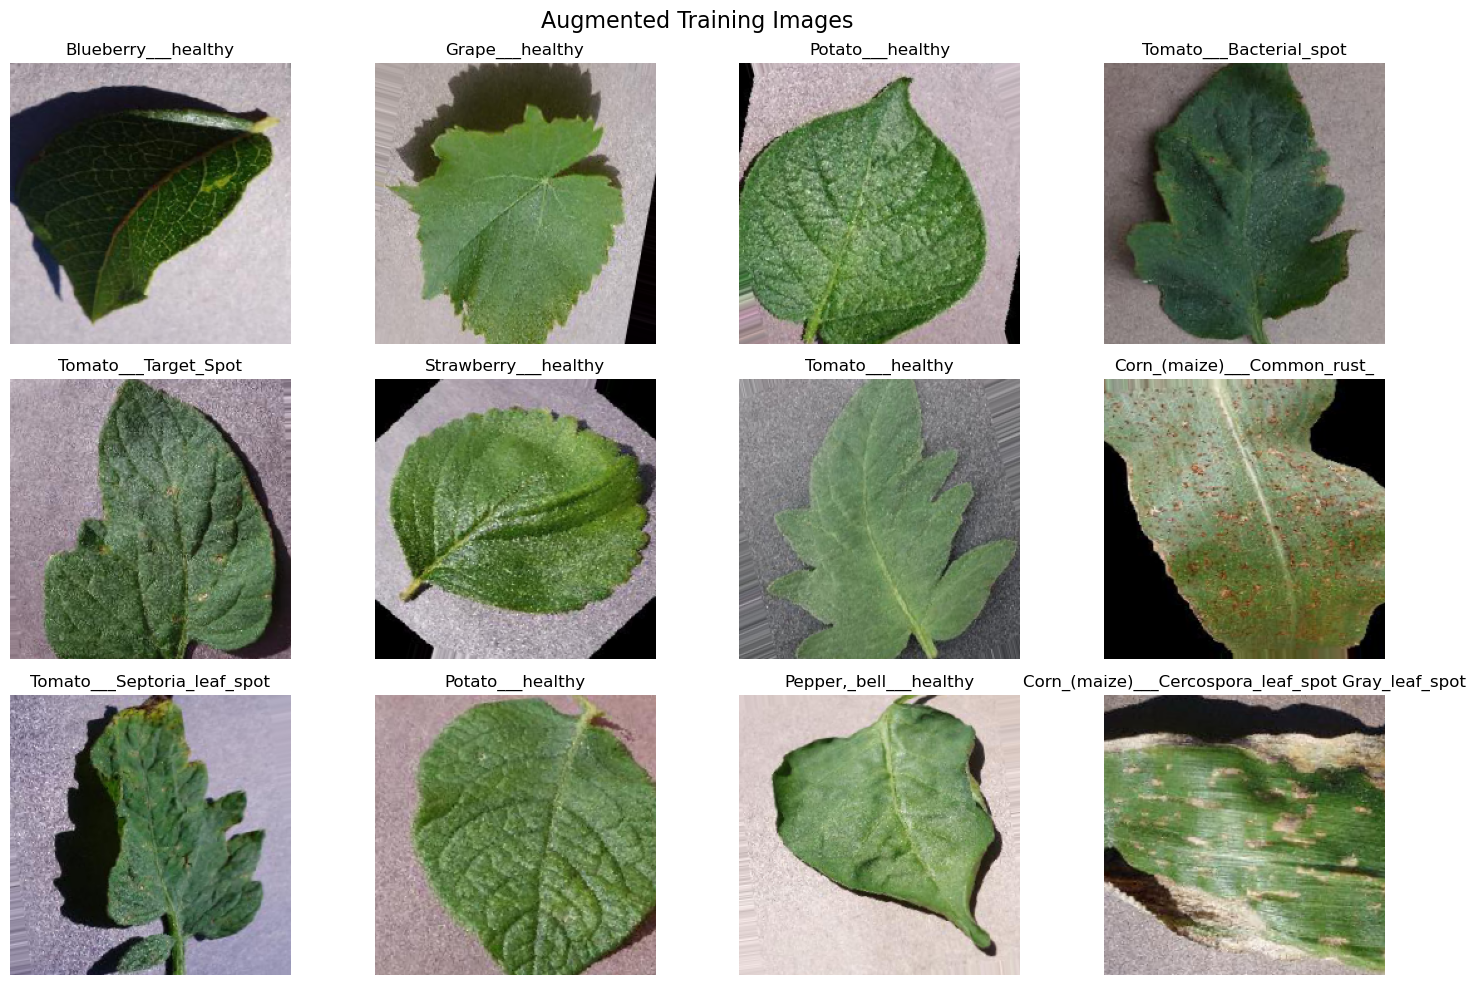

In [4]:
# Get class labels mapping
class_labels = list(train_gen.class_indices.keys())

# Fetch one batch of images and labels
images, labels = next(train_gen)

# Plot the first 12 images in the batch
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_labels[label_index])
    plt.axis('off')

plt.suptitle("Augmented Training Images", fontsize=16)
plt.tight_layout()
plt.show()

## Model Building (Transfer Learning with MobileNetV2):

In [5]:
# Base Model: MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Custom top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Callbacks (Checkpoints, EarlyStop, LR Reduce)

In [6]:
os.makedirs("outputs/saved_model", exist_ok=True)

checkpoint_path = "outputs/saved_model/best_model.keras"

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

## Initial Training (Frozen):

In [7]:
# Initial training
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

C:\Users\etern\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.7354 - loss: 0.9184
Epoch 1: val_loss improved from inf to 0.26402, saving model to outputs/saved_model/best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2379s 1s/step - accuracy: 0.7354 - loss: 0.9182 - val_accuracy: 0.9112 - val_loss: 0.2640 - learning_rate: 0.0010
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.8923 - loss: 0.3232
Epoch 2: val_loss improved from 0.26402 to 0.25604, saving model to outputs/saved_model/best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2086s 949ms/step - accuracy: 0.8923 - loss: 0.3232 - val_accuracy: 0.9133 - val_loss: 0.2560 - learning_rate: 0.0010
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.9035 - loss: 0.2888
Epoch 3: val_loss improved from 0.25604 to 0.21089, saving model to outputs/saved_model/best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2106s 959ms/step - accuracy: 0.9035 - loss: 0.2888 - val_accuracy: 0.9284 - val_loss: 0.2109 - 

## Fine-Tuning (Unfreezing Last 30 Layers)

In [8]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
fine_tune_history = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7828 - loss: 0.9038
Epoch 1: val_loss did not improve from 0.14275
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3696s 2s/step - accuracy: 0.7828 - loss: 0.9037 - val_accuracy: 0.9387 - val_loss: 0.1831 - learning_rate: 1.0000e-05
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9195 - loss: 0.2372
Epoch 2: val_loss did not improve from 0.14275
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2033s 925ms/step - accuracy: 0.9195 - loss: 0.2372 - val_accuracy: 0.9471 - val_loss: 0.1574 - learning_rate: 1.0000e-05
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9394 - loss: 0.1754
Epoch 3: val_loss improved from 0.14275 to 0.13048, saving model to outputs/saved_model/best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1743s 794ms/step - accuracy: 0.9394 - loss: 0.1754 - val_accuracy: 0.9558 - val_loss: 0.1305 - learning_rate: 1.0000e-05
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9517 - loss

## Evaluation Metrics:

In [10]:
# Predict on the validation set
y_pred = model.predict(valid_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

550/550 ━━━━━━━━━━━━━━━━━━━━ 308s 558ms/step


In [28]:
# Get class label mapping
class_indices = valid_gen.class_indices
class_labels = list(class_indices.keys())

# Print prediction percentages for each sample
confidence_percentages = np.max(y_pred, axis=1) * 100

# Create a DataFrame for easy viewing
pred_df = pd.DataFrame({
    "True Label": [class_labels[i] for i in y_true],
    "Predicted Label": [class_labels[i] for i in y_pred_labels],
    "Confidence (%)": confidence_percentages.round(2)
})

# Show top 10 predictions
print(pred_df.head(10))

           True Label     Predicted Label  Confidence (%)
0  Apple___Apple_scab  Apple___Apple_scab      100.000000
1  Apple___Apple_scab  Apple___Apple_scab      100.000000
2  Apple___Apple_scab  Apple___Apple_scab      100.000000
3  Apple___Apple_scab  Apple___Apple_scab      100.000000
4  Apple___Apple_scab  Apple___Apple_scab       98.809998
5  Apple___Apple_scab  Apple___Apple_scab       98.779999
6  Apple___Apple_scab  Apple___Apple_scab      100.000000
7  Apple___Apple_scab  Apple___Apple_scab      100.000000
8  Apple___Apple_scab  Apple___Apple_scab      100.000000
9  Apple___Apple_scab  Apple___Apple_scab      100.000000


## Classification Report:

In [29]:
print(classification_report(y_true, y_pred_labels, target_names=list(valid_gen.class_indices.keys())))

# F1-score
f1 = f1_score(y_true, y_pred_labels, average='macro')
print("Macro F1-score:", round(f1, 4))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.99      0.99       504
                                 Apple___Black_rot       0.99      1.00      0.99       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      0.98      0.99       502
                               Blueberry___healthy       0.99      0.98      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       421
                 Cherry_(including_sour)___healthy       0.98      1.00      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.94      0.94       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.94      0.

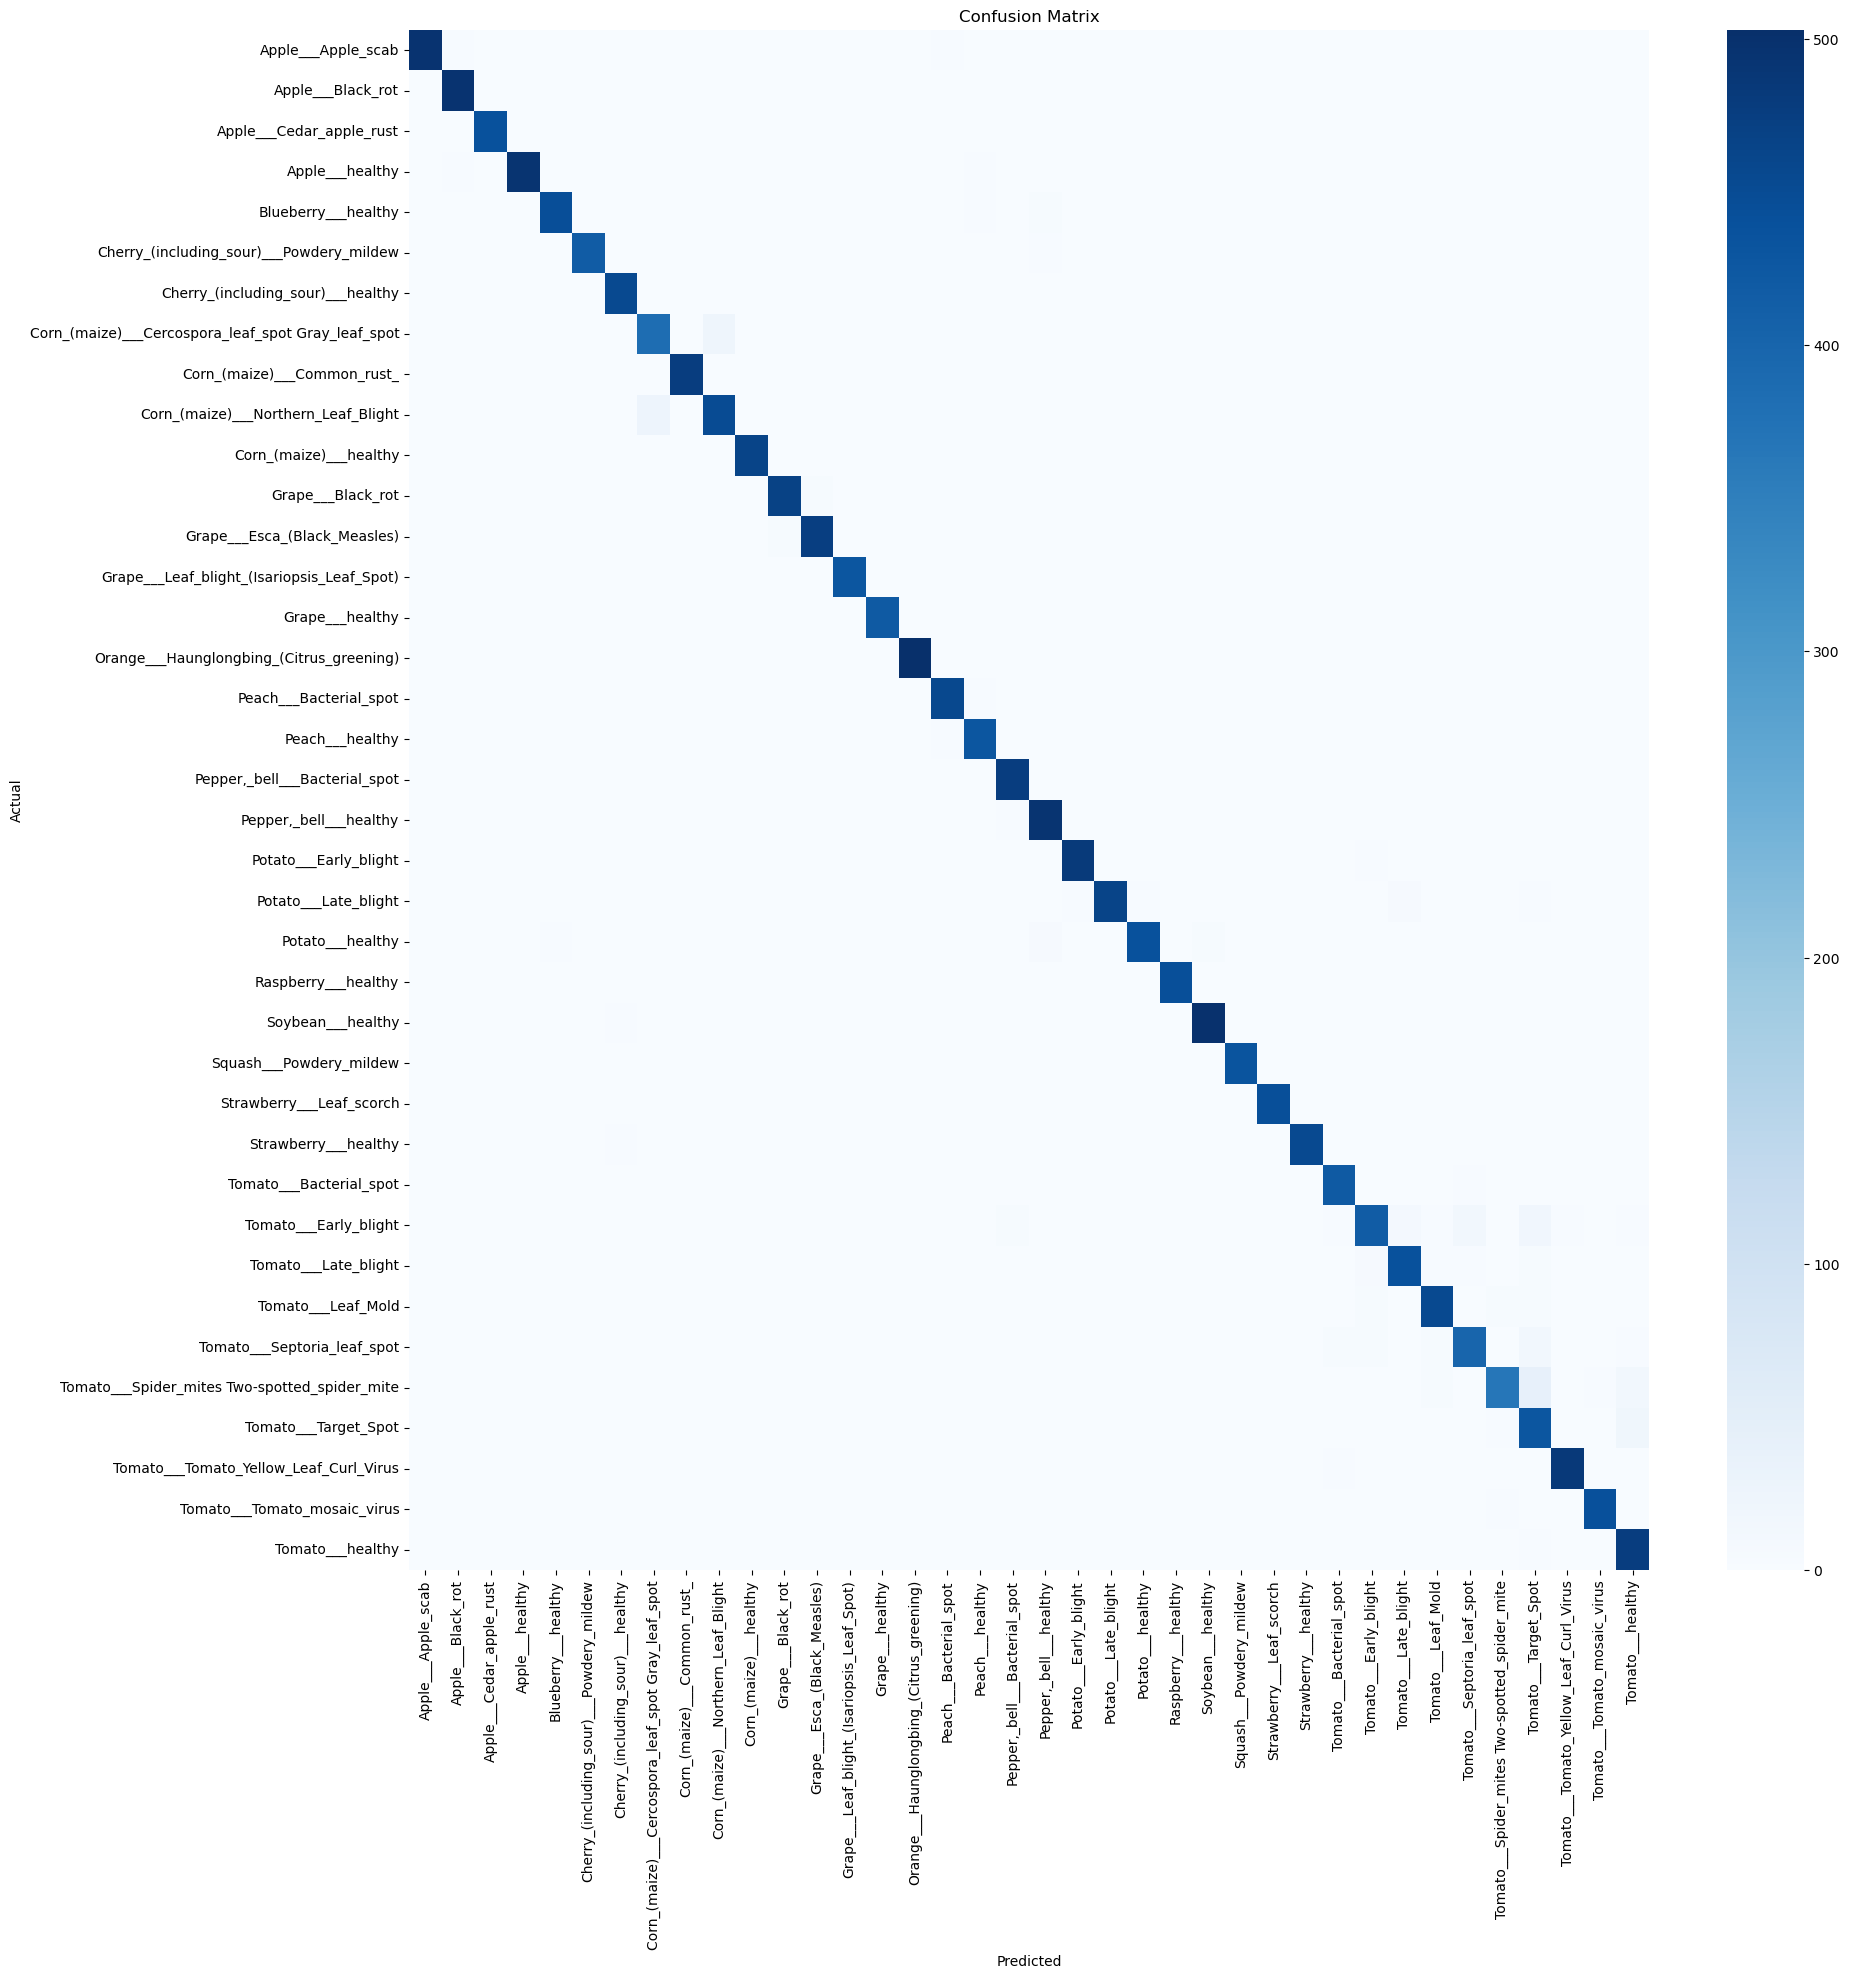

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=valid_gen.class_indices.keys(),
            yticklabels=valid_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Training History Visualization:

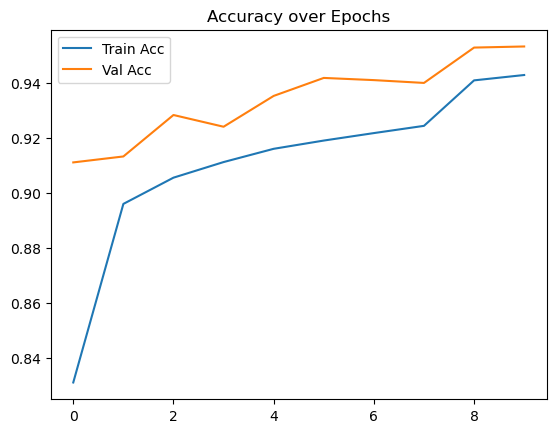

In [30]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

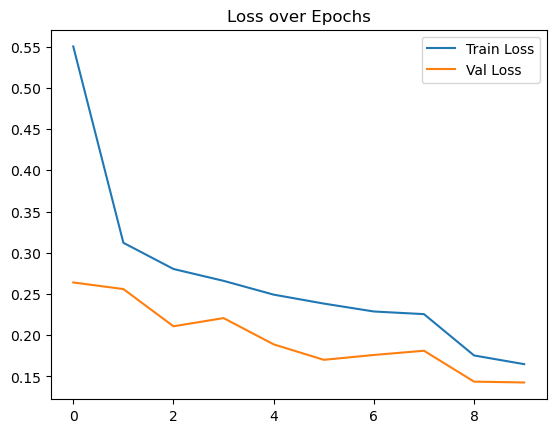

In [31]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

## Save Model:

In [32]:
final_model_path = "outputs/saved_model/plant_disease_model_final.keras"
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")

Final model saved at: outputs/saved_model/plant_disease_model_final.keras


## Model summary:

In [33]:
# Weights of the last Dense layer
final_dense_layer = model.layers[-1]
weights, biases = final_dense_layer.get_weights()

print("Weights shape:", weights.shape)
print("Biases shape:", biases.shape)

# Small sample
print("Sample weights:\n", weights[:5][:5])
print("Sample biases:\n", biases[:5])

Weights shape: (128, 38)
Biases shape: (38,)
Sample weights:
 [[-0.08373749  0.0546422  -0.17322516 -0.15768147 -0.12192512  0.06259006
  -0.16212913  0.07966855 -0.18181166  0.05610481 -0.05516002  0.24320659
   0.151786    0.14764455  0.12461261 -0.28467047 -0.02758055 -0.19738276
  -0.06622922 -0.18167037  0.07447036  0.01901804 -0.09730174 -0.1866781
   0.02366381  0.17620297 -0.03222799 -0.06733461 -0.03828813 -0.04568949
   0.068003    0.06978236 -0.07333124 -0.10908637 -0.05464167 -0.22146091
  -0.12839493  0.10700216]
 [ 0.15578137 -0.12465144 -0.05268598 -0.15208198 -0.05906035 -0.09438353
  -0.4206372   0.2145085   0.09802106  0.19926098 -0.05175479  0.1331152
  -0.09873723  0.21754918 -0.10085731 -0.02696355  0.10420037 -0.27950346
   0.09069612 -0.11289021  0.15345551 -0.04743753 -0.23291473 -0.21646552
  -0.26823875 -0.15368022  0.17250583 -0.10452194  0.03365938  0.08164057
  -0.22160687 -0.15006833  0.05985455 -0.11582748 -0.17532739 -0.06448366
  -0.02616566 -0.3557696 

In [18]:
# number of trainable parameters in each layer
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 5,817,396 (22.19 MB)

 Trainable params: 1,695,270 (6.47 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 3,390,542 (12.93 MB)

# Load the trained model and evaluate:

In [19]:
# Imports
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# from sklearn.metrics import classification_report, confusion_matrix, f1_score
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
# ImageDataGenerator (same as training)
# valid_dir = '../dataset/plant_dataset/valid'

# valid_datagen = ImageDataGenerator(rescale=1./255)

# valid_gen = valid_datagen.flow_from_directory(
#     valid_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )

In [21]:
# Load trained model
# model_path = "outputs/saved_model/best_model.keras"
# model = load_model(model_path)

# print(f"Loaded model from: {model_path}")

In [22]:
# Predict on validation data
# y_pred_probs = model.predict(valid_gen)
# y_pred_labels = np.argmax(y_pred_probs, axis=1)
# y_true = valid_gen.classes

In [23]:
# Class label mapping
# class_labels = list(valid_gen.class_indices.keys())

In [24]:
# Classification Report
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred_labels, target_names=class_labels))

In [25]:
# Macro F1 Score
# f1 = f1_score(y_true, y_pred_labels, average='macro')
# print(f"\nMacro F1-score: {f1:.4f}")

In [26]:
# Confusion Matrix
# cm = confusion_matrix(y_true, y_pred_labels)

# plt.figure(figsize=(20, 20))
# sns.heatmap(cm, annot=False, cmap="Blues",
#             xticklabels=class_labels,
#             yticklabels=class_labels)
# plt.title("Corrected Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.tight_layout()
# plt.show()

In [27]:
# Confidence Table
# confidence_percentages = np.max(y_pred_probs, axis=1) * 100

# pred_df = pd.DataFrame({
#     "True Label": [class_labels[i] for i in y_true],
#     "Predicted Label": [class_labels[i] for i in y_pred_labels],
#     "Confidence (%)": confidence_percentages.round(2)
# })

# print("\nSample Predictions:")
# print(pred_df.head(10))